# Imports and setup

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time

import kagglehub


/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [4]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset perso

In [5]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [6]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# CelebA

In [7]:


# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

for root, dirs, files in os.walk(path):
    print(f"Dossier: {root}")
    print(f"Sous-dossiers: {dirs}")
    print(f"Fichiers (premiers 5): {files[:5]}")
    break



  1%|▏         | 20.0M/1.33G [00:01<01:38, 14.3MB/s]


KeyboardInterrupt: 

In [7]:


from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
import random

# Définir les transformations pour redimensionner les images à 64x64
transform = Compose([
    Resize((128, 128)),  # Redimensionner les images à 64x64
    ToTensor(),        # Convertir en tenseur PyTorch
    Normalize((0.5,), (0.5,))  # Normaliser les pixels entre -1 et 1
])

# Charger le dataset complet
dataset_path = "/home/e20220005499/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2"
human_faces_dataset = ImageFolder(root=dataset_path, transform=transform)

# Réduire à 10% du dataset
dataset_size = len(human_faces_dataset)
subset_size = int(0.05 * dataset_size)
indices = random.sample(range(dataset_size), subset_size)
subset_dataset = Subset(human_faces_dataset, indices)

# Diviser le sous-dataset en train/test
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Nombre d'images dans le sous-dataset : {len(subset_dataset)}")
print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")



FileNotFoundError: [Errno 2] No such file or directory: '/home/e20220005499/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2'

# Data Augmentation

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


# Paramètres

In [8]:

EMBEDDING_SIZE = 64
BATCH_SIZE = 32

EPOCHS = 100

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.929411768913269
Max pixel value: 1.0
Mean pixel value: 0.041548848152160645


train samples: 65, test samples: 19, nb_classes: 10
train Class 0: 8 samples
train Class 1: 6 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 5 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 1 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


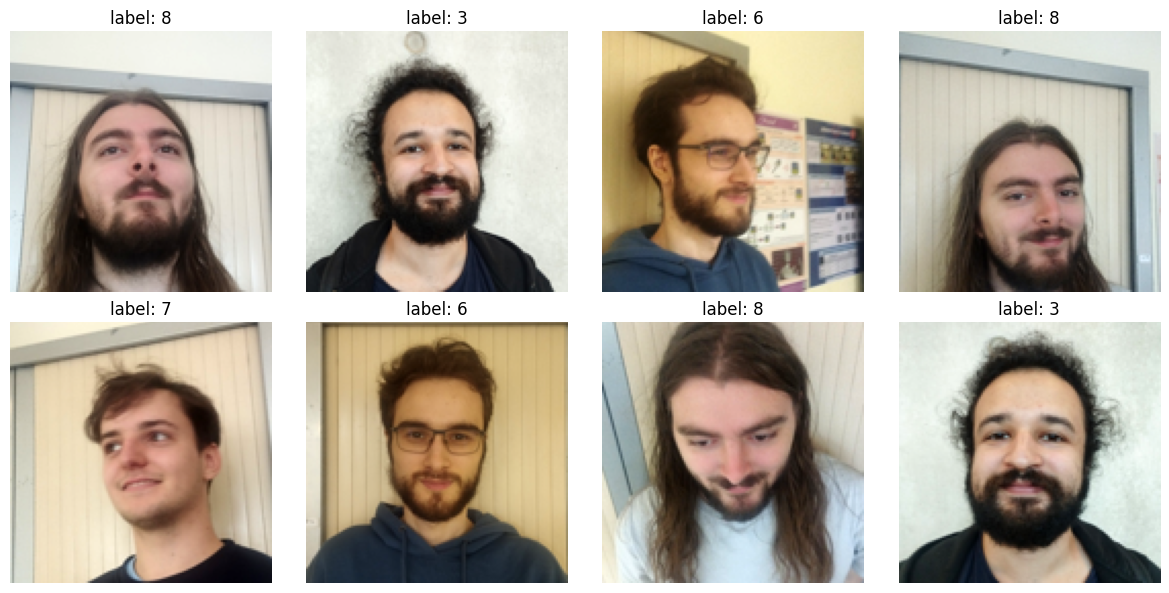

In [11]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [438]:

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), EMBEDDING_SIZE)

    def forward(self, x):
        res = self.conv(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        res = F.normalize(res, p=2, dim=1)
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [475]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


Embedder has 1050080 parameters
Epoch 1, Training Loss: 0.7864, Validation Loss: 1.1028
Epoch 2, Training Loss: 0.7461, Validation Loss: 1.0426
Epoch 3, Training Loss: 0.7412, Validation Loss: 1.0295
Epoch 4, Training Loss: 0.7228, Validation Loss: 1.0269
Epoch 5, Training Loss: 0.7120, Validation Loss: 1.0206
Epoch 6, Training Loss: 0.7104, Validation Loss: 1.0203
Epoch 7, Training Loss: 0.6823, Validation Loss: 1.0194
Epoch 8, Training Loss: 0.6810, Validation Loss: 1.0202
Epoch 9, Training Loss: 0.6573, Validation Loss: 1.0161
Epoch 10, Training Loss: 0.6630, Validation Loss: 1.0136
Epoch 11, Training Loss: 0.6470, Validation Loss: 1.0089
Epoch 12, Training Loss: 0.6306, Validation Loss: 1.0033
Epoch 13, Training Loss: 0.6322, Validation Loss: 0.9985
Epoch 14, Training Loss: 0.6197, Validation Loss: 0.9941
Epoch 15, Training Loss: 0.6154, Validation Loss: 0.9900
Epoch 16, Training Loss: 0.6075, Validation Loss: 0.9841
Epoch 17, Training Loss: 0.5884, Validation Loss: 0.9792
Epoch 18

In [ ]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

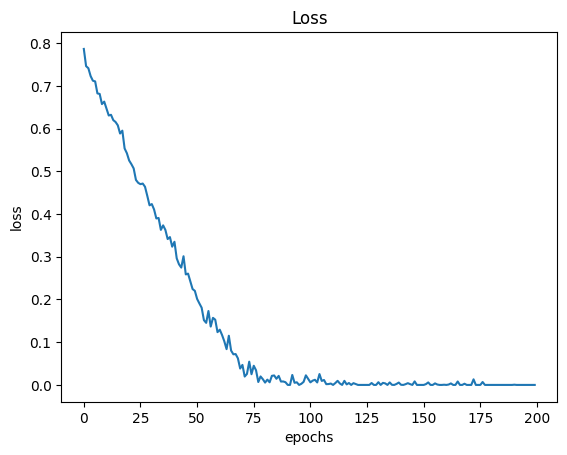

In [476]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [477]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [-0.017380659090122208, -0.10679822228848934, 0.15227024629712105, 0.08050528774037957, -0.024627351172966883, 0.15400986559689045, 0.04908612713916227, -0.16418603621423244, -0.012874295432993677, -0.1743204966187477, -0.21113754250109196, 0.2095977794378996, -0.27815161272883415, 0.06975096091628075, 0.10080247931182384, -0.07398739457130432, 0.05748824053443968, -0.14573545847088099, 0.07234585471451283, -0.08785670902580023, 0.021471418789587915, -0.04422360030002892, 0.08024803036823869, 0.12195663712918758, 0.009182055455312366, -0.21128471940755844, 0.010738618506366038, 0.01406081166351214, -0.20772680640220642, -0.07511685555800796, 0.011765540577471256, -0.02096685516880825, -0.11386880371719599, 0.021965426276437938, 0.20673019625246525, -0.014356980769662187, 0.13672179449349642, -0.10324027948081493, 0.07348705688491464, -0.0546152857132256, 0.15606881026178598, 0.1828805897384882, 0.059707738226279616, -0.07484146440401673, 0.05158403771929443, -

In [478]:
faceEmbedder.eval()

misclassified_images = []
true_labels = []
predicted_labels = []

avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min != labels[0].item():
            misclassified_images.append(images[0].cpu())
            true_labels.append(labels[0].item())
            predicted_labels.append(i_min)


n = len(misclassified_images)
cols = 4
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")
    if i < n:
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

### Plot embeddings

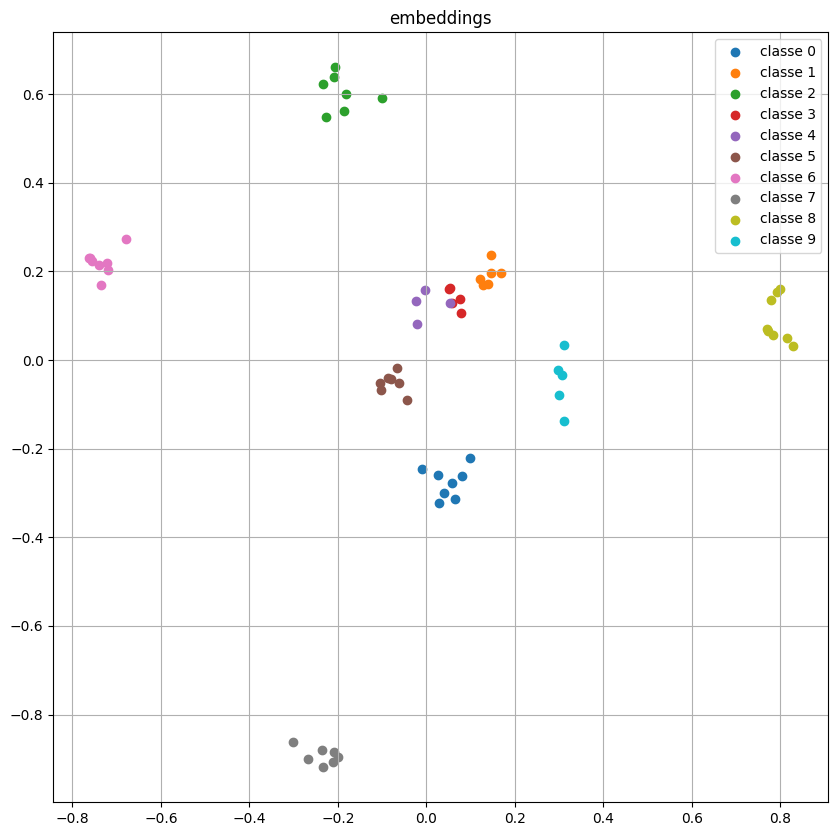

In [479]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [62]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(1250):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.3269, test loss: 2.3145
Epoch 2, training loss: 2.2776, test loss: 2.3083
Epoch 3, training loss: 2.3004, test loss: 2.3023
Epoch 4, training loss: 2.2924, test loss: 2.2966
Epoch 5, training loss: 2.2490, test loss: 2.2909
Epoch 6, training loss: 2.2352, test loss: 2.2854
Epoch 7, training loss: 2.2664, test loss: 2.2802
Epoch 8, training loss: 2.2399, test loss: 2.2750
Epoch 9, training loss: 2.2167, test loss: 2.2700
Epoch 10, training loss: 2.2229, test loss: 2.2650
Epoch 11, training loss: 2.1992, test loss: 2.2601
Epoch 12, training loss: 2.2109, test loss: 2.2552
Epoch 13, training loss: 2.2327, test loss: 2.2503
Epoch 14, training loss: 2.1763, test loss: 2.2453
Epoch 15, training loss: 2.2079, test loss: 2.2403
Epoch 16, training loss: 2.1622, test loss: 2.2354
Epoch 17, training loss: 2.2020, test loss: 2.2306
Epoch 18, training loss: 2.1453, test loss: 2.2258
Epoch 19, training loss: 2.1748, test loss: 2.2209
Epoch 20, training loss: 2.1665, test lo

## Analyse

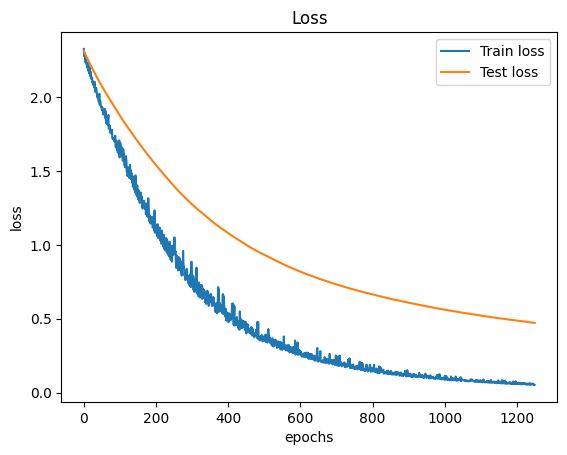

In [63]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

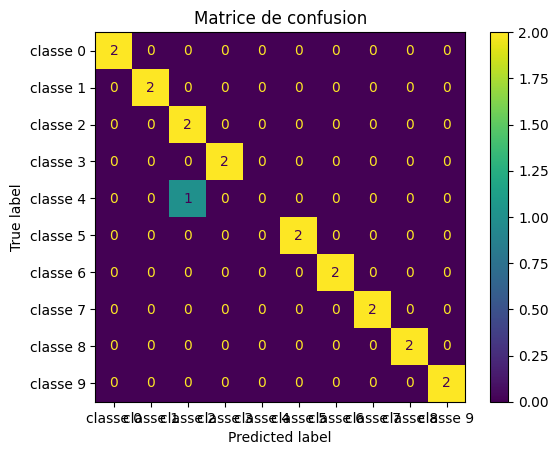

accuracy on test set: 94.74% (18/19)


In [64]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

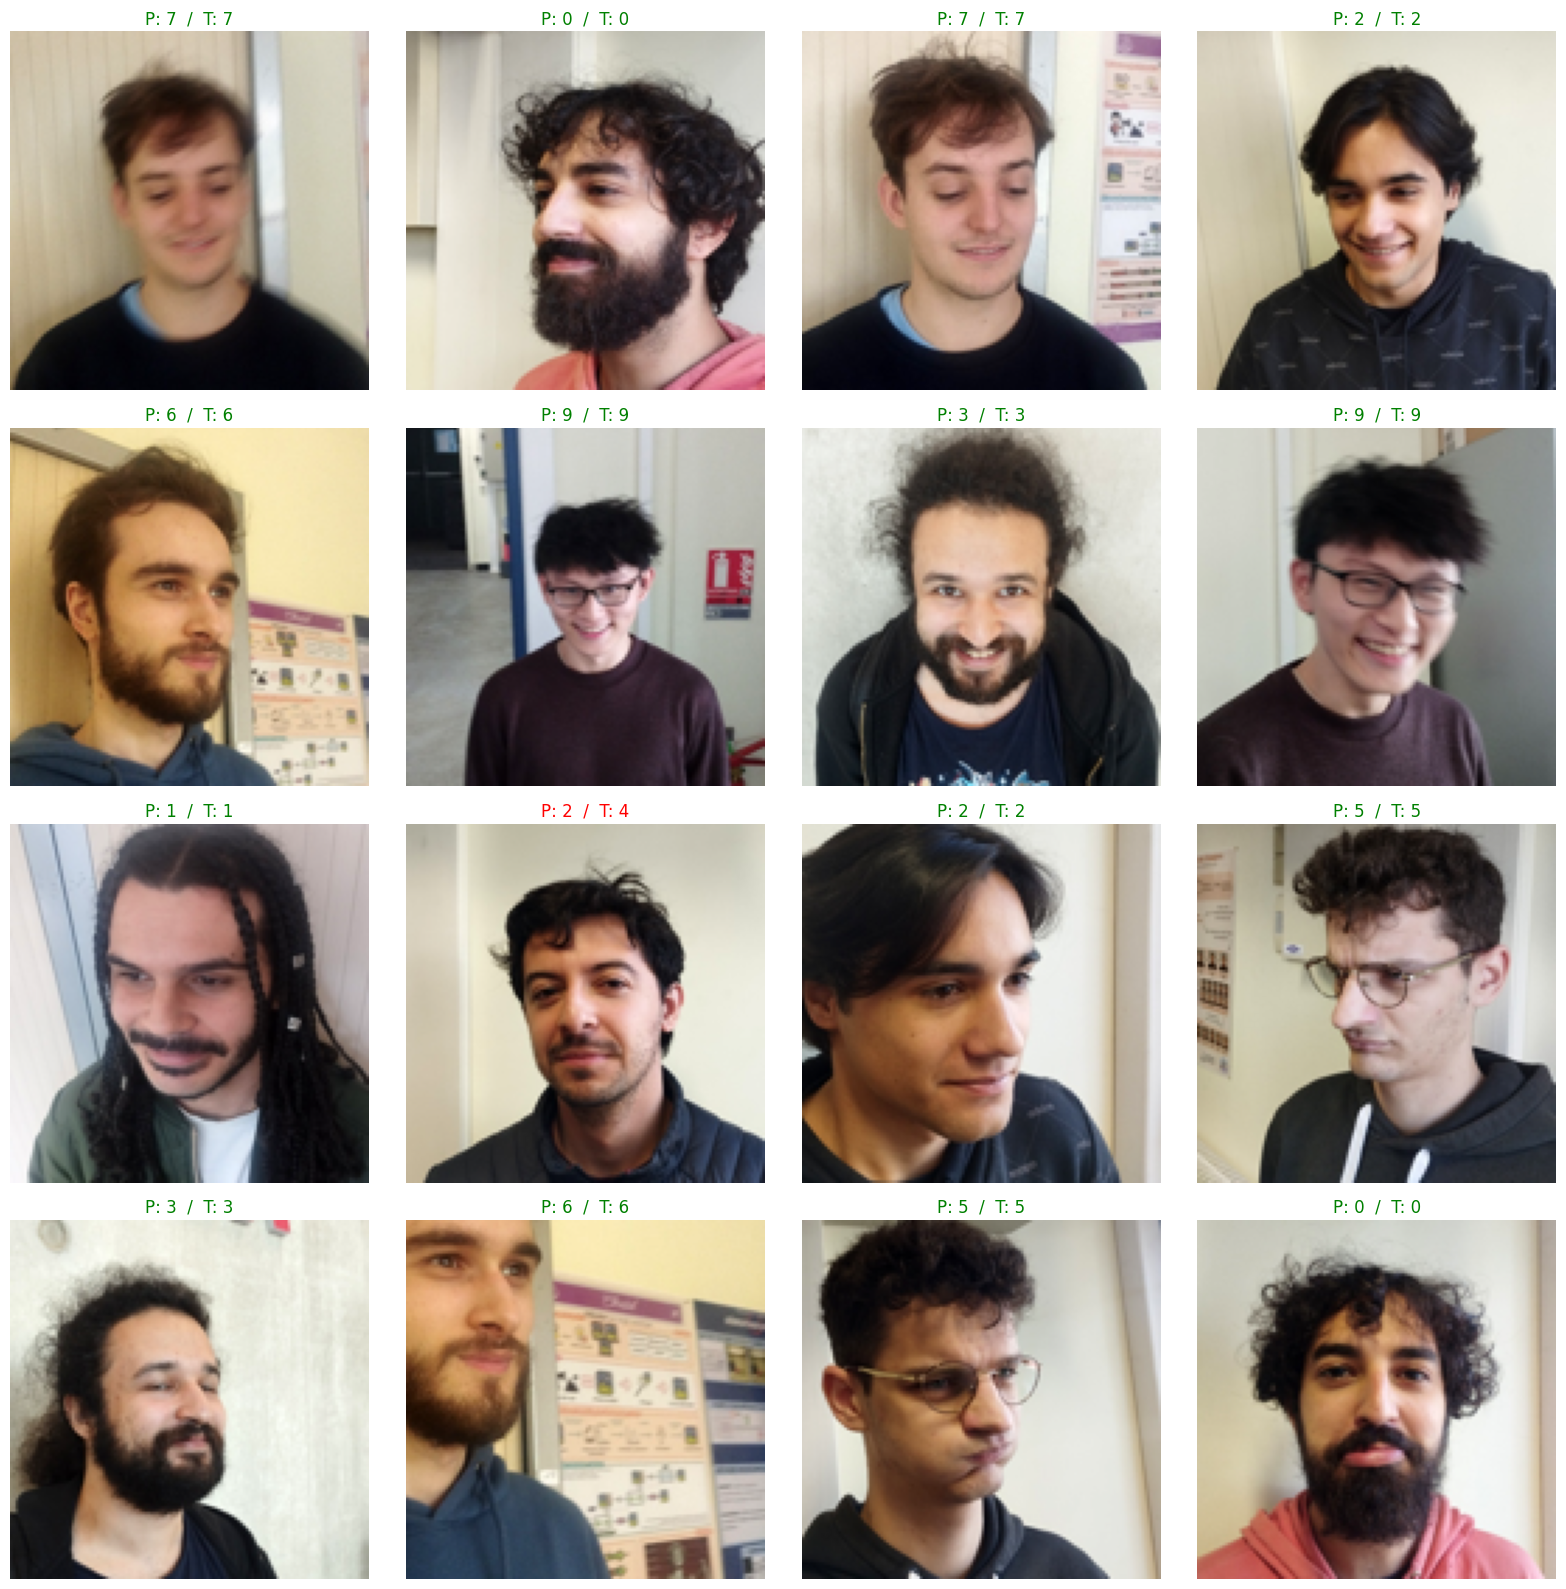

In [67]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# GAN ahahahahaha

## Better segmentation

In [11]:
from face_parsing.resnet import *
from face_parsing.bisenet import BiSeNet

def load_model(model_name: str, num_classes: int, weight_path: str, device: torch.device) -> torch.nn.Module:
    """
    Load and initialize the BiSeNet model.

    Args:
        model_name: Name of the backbone model (e.g., "resnet18")
        num_classes: Number of segmentation classes
        weight_path: Path to the model weights file
        device: Device to load the model onto

    Returns:
        torch.nn.Module: Initialized and loaded model
    """
    model = BiSeNet(num_classes, backbone_name=model_name)
    model.to(device)

    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path, map_location=device))
    else:
        raise ValueError(f"Weights not found from given path ({weight_path})")

    model.eval()
    return model

In [12]:
segmentor = load_model("resnet18", 19,"./models/resnet18.pt", device)
#segmentor.load_state_dict(torch.load("models/resnet18.pt"),)
segmentor = segmentor.to(device)
segmentor.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/e20220005499/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s] 



BiSeNet(
  (fpn): ContextPath(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNor

In [15]:
def preprocess_for_segmentor(images, device, target_size=512):
    """
    Prepare a batch tensor for the BiSeNet segmentor.
    - images: torch.Tensor [B,C,H,W], possibly in [-1,1] or [0,1]
    - returns normalized tensor on device with size (B,3,target_size,target_size)
    """
    imgs = images.clone().to(device)

    if imgs.min() < -0.5:
        imgs = (imgs + 1.0) / 2.0
    imgs = torch.clamp(imgs, 0.0, 1.0)

    imgs = F.interpolate(imgs, size=(target_size, target_size), mode='bilinear', align_corners=False)

    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    imgs = (imgs - mean) / std
    return imgs

In [ ]:

from torchvision.transforms.functional import to_pil_image



images, labels = next(iter(test_loader))
orig_images = images.clone() 
orig_h, orig_w = images.size(2), images.size(3)

prep = preprocess_for_segmentor(images, device, target_size=512)

with torch.no_grad():
    outputs = segmentor(prep)

    if isinstance(outputs, (list, tuple)):
        seg_logits = outputs[0]
    else:
        seg_logits = outputs

    seg = seg_logits.argmax(dim=1, keepdim=True).float()

    seg_resized = F.interpolate(seg, size=(orig_h, orig_w), mode='nearest').squeeze(1).cpu().numpy()

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = orig_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
    img_disp = (img - mi) / denom
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"class {labels[i].item()}")
    axs[0, i].axis("off")

    seg_map = seg_resized[i]
    axs[1, i].imshow(seg_map, cmap="jet")
    axs[1, i].set_title("segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


face_class_ids = [1,2,3,4,5,6,9,10,11,12,13]  
extracted_faces = []

for i in range(images.size(0)):
    img = orig_images[i].permute(1, 2, 0).cpu().numpy()
    seg_map = seg_resized[i]

    face_mask = np.isin(seg_map, face_class_ids).astype(np.uint8)


    face = img * face_mask[:, :, np.newaxis]

    y_indices, x_indices = np.where(face_mask)
    if y_indices.size > 0 and x_indices.size > 0:
        y_min, y_max = y_indices.min(), y_indices.max()
        x_min, x_max = x_indices.min(), x_indices.max()
        face = face[y_min:y_max + 1, x_min:x_max + 1]

    extracted_faces.append(face)


n = min(8, len(extracted_faces))
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i in range(n):
    face = extracted_faces[i]
    mi, ma = face.min(), face.max()
    denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
    face_disp = (face - mi) / denom
    axs[i].imshow(face_disp)
    axs[i].axis("off")
plt.tight_layout()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 608.00 MiB. GPU 0 has a total capacity of 9.63 GiB of which 295.88 MiB is free. Including non-PyTorch memory, this process has 8.42 GiB memory in use. Of the allocated memory 7.14 GiB is allocated by PyTorch, and 1.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## FSGAN Segmentation

In [13]:
from fsgan.simple_unet_02 import UNet

model_path = "fsgan/weights/celeba_unet_256_1_2_segmentation_v2.pth"

weights = torch.load(model_path, map_location=device)
state_dict = weights['state_dict'] if isinstance(weights, dict) and 'state_dict' in weights else weights
new_state = {} 
for k, v in state_dict.items(): 
    new_key = k[7:] if k.startswith('module.') else k 
    new_state[new_key] = v

num_classes = None
for k in new_state.keys():
    if k.endswith("final.weight") or k.endswith("final.conv.weight") or ("final" in k and k.endswith("weight")):
        num_classes = new_state[k].shape[0]
        break
if num_classes is None:
    print("NUM CLASSES NONE")
    num_classes = 1


segmentor = UNet(num_classes=num_classes).to(device)


segmentor.load_state_dict(new_state, strict=False)
segmentor.to(device)
segmentor.eval()
model_parameters = filter(lambda p: p.requires_grad, segmentor.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Segmentor has {params} parameters")


Segmentor has 28950851 parameters


In [14]:
import gc

gc.collect()
torch.cuda.empty_cache()

print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

GPU memory allocated: 333.2 MB
GPU memory reserved: 346.0 MB


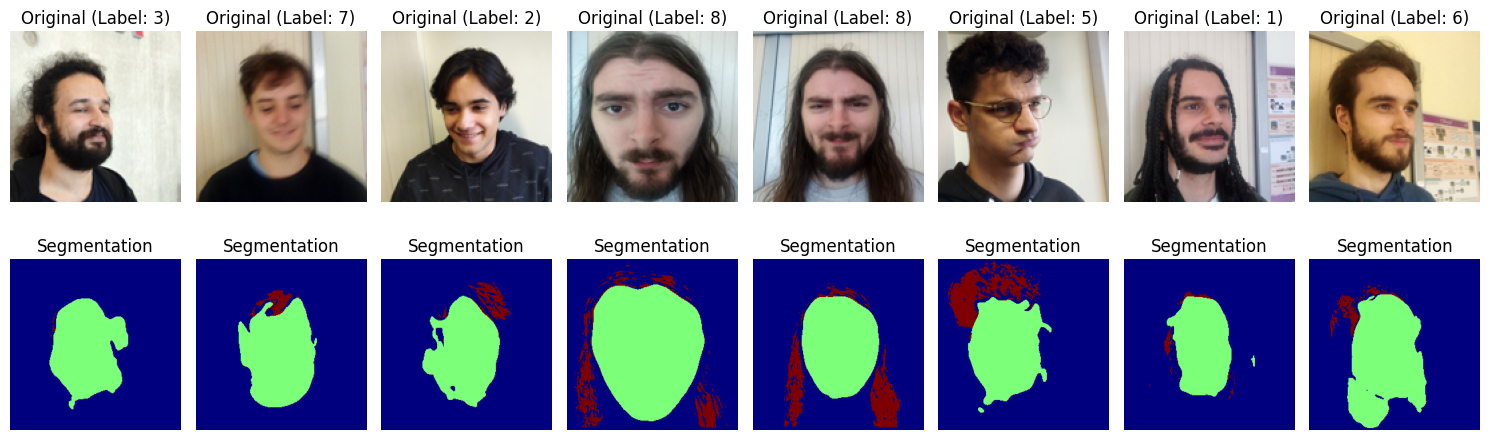

In [15]:
# Test the segmentor with a batch of images from the test_loader
images, labels = next(iter(test_loader))
images = images.to(device)

# Normalize the images for the segmentor
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
normalized_images = (images + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
normalized_images = (normalized_images - mean) / std

# Resize the images to the target size (512x512)
resized_images = F.interpolate(normalized_images, size=(256, 256), mode='bilinear', align_corners=False)

# Pass the resized images through the segmentor
with torch.no_grad():
    outputs = segmentor(resized_images)

    # Extract the segmentation logits
    seg_logits = outputs[0] if isinstance(outputs, (list, tuple)) else outputs

    # Get the segmentation map by taking the argmax
    seg_map = seg_logits.argmax(dim=1).cpu().numpy()

# Visualize the original images and their corresponding segmentation maps
n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    # Segmentation map
    axs[1, i].imshow(seg_map[i], cmap="jet")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

## FSGAN Landmarks

In [34]:
import os
import torch
from fsgan.hrnet import hrnet_wlfw

def strip_module_prefix(state_dict):
    new = {}
    for k, v in state_dict.items():
        new_k = k[7:] if k.startswith('module.') else k
        new[new_k] = v
    return new

def load_hr18_landmarks(model_path, device=None, strict=True):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    device = torch.device("cuda" if torch.cuda.is_available() and (device is None or str(device).startswith("cuda")) else "cpu") \
             if device is None else torch.device(device)

    # instantiate model
    model = hrnet_wlfw().to(device)

    # load checkpoint
    ckpt = torch.load(model_path, map_location=device)

    # extract state_dict whether ckpt is { 'state_dict': ... } or a raw state_dict
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    # sometimes keys are saved with "module." prefix
    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = strip_module_prefix(state_dict)

    # try loading (fallback to strict=False on failure)
    try:
        model.load_state_dict(state_dict, strict=strict)
    except RuntimeError as e:
        # try again with strict=False to allow minor mismatches
        print("Strict load failed, retrying with strict=False. Error:", e)
        model.load_state_dict(state_dict, strict=False)

    model.eval()
    return model

# Example usage:
# model = load_hr18_landmarks("weights/hr18_wflw_landmarks.pth")
# print(model)

In [33]:
import torch, gc


del resized_images

# 2) free Python garbage and sync CUDA
torch.cuda.synchronize()
gc.collect()

# 3) release cached GPU memory
torch.cuda.empty_cache()

NameError: name 'resized_images' is not defined

In [35]:
model_path = "weights/hr18_wflw_landmarks.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pass the path as pretrained so model.init_weights will load keys that match
model = hrnet_wlfw(pretrained=model_path)
model.eval()

HighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (sf): Softmax(dim=1)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=Tr

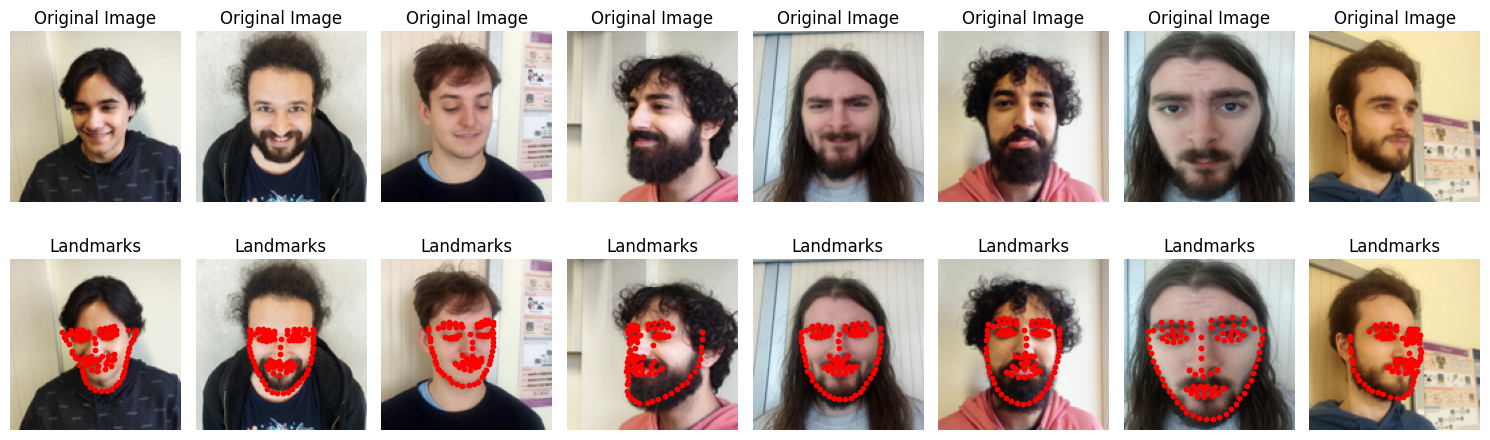

In [48]:
import torch
import torch.nn.functional as F
from fsgan.hrnet import hrnet_wlfw            # correct import
from fsgan.landmarks_utils import LandmarksHeatMapEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model + weights
model = hrnet_wlfw().to(device).eval()
state = torch.load('fsgan/weights/hr18_wflw_landmarks.pth', map_location=device)
if isinstance(state, dict) and 'state_dict' in state: state = state['state_dict']
state = {k[7:]: v for k, v in state.items()} if next(iter(state)).startswith('module.') else state
model.load_state_dict(state, strict=False)

# batch
images, _ = next(iter(test_loader))         # images in [-1,1] or [0,1]
images = images.to(device)

# preprocess for HRNet: 256 and ImageNet norm
imgs = images
if imgs.min() < 0:                          # if in [-1,1], bring to [0,1]
    imgs = (imgs + 1.0) / 2.0
mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
imgs = F.interpolate(imgs, size=(256,256), mode='bilinear', align_corners=False)
imgs = (imgs - mean) / std

# forward
with torch.no_grad():
    H = model(imgs)                         # (B,98,64,64) heatmaps
    enc = LandmarksHeatMapEncoder(size=H.shape[-1]).to(device)
    L = enc(H)                              # (B,98,2) in [0,1]
    # fallback if encoder zeroes out
    flat = H.view(H.shape[0], H.shape[1], -1); idx = flat.argmax(2)
    xs_arg = (idx % H.shape[-1]).float() / H.shape[-1]
    ys_arg = (idx // H.shape[-1]).float() / H.shape[-1]
    deg = ((H.view(H.shape[0], H.shape[1], -1).max(-1).values - H.view(H.shape[0], H.shape[1], -1).min(-1).values) < 1e-5)
    if deg.any():
        b, c = deg.nonzero(as_tuple=True)
        L[b, c, 0] = xs_arg[b, c]; L[b, c, 1] = ys_arg[b, c]

# L now contains valid normalized landmark coords (multiply by 256 for pixels)

# Visualize the results
n = min(8, images.size(0))  # Number of images to display
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original Image")
    axs[0, i].axis("off")

    # Landmarks
    landmarks = L[i].cpu().numpy() * 128  # Scale normalized coords to pixel values
    axs[1, i].imshow(img_disp)
    axs[1, i].scatter(landmarks[:, 0], landmarks[:, 1], c="red", s=10)
    axs[1, i].set_title("Landmarks")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

## Entrainement

In [502]:
def Conv(in_ch, out_ch, norm=True):
    layers = [
        nn.Conv2d(in_ch, out_ch, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    if norm:
        layers.append(nn.InstanceNorm2d(out_ch))
    return nn.Sequential(*layers)

def Deconv(in_ch, out_ch, norm=True):
    layers = [
        nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1),
        nn.ReLU(inplace=True)
    ]
    if norm:
        layers.append(nn.InstanceNorm2d(out_ch))
    return nn.Sequential(*layers)

class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.slice = nn.Sequential(*vgg[:16])
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x, y):
        return F.l1_loss(self.slice(x), self.slice(y))


In [503]:
class SwapGenerator(nn.Module):
    def __init__(self, id_dim=128):
        super().__init__()

        # ---------- Encoder (Structure/Attribute Extractor) ----------
        self.enc1 = Conv(3,   64, norm=False)  # 128 → 64
        self.enc2 = Conv(64, 128)              # 64 → 32
        self.enc3 = Conv(128,256)              # 32 → 16
        self.enc4 = Conv(256,512)              # 16 → 8

        # ---------- Identity Encoder (Project embedding to feature space) ----------
        self.id_encoder = nn.Sequential(
            nn.Linear(id_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512 * 8 * 8)
        )

        # ---------- Fusion Layer ----------
        self.fusion = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),  # 512 (structure) + 512 (identity)
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )

        # ---------- Decoder ----------
        self.dec1 = Deconv(512,256)            # 8 → 16
        self.dec2 = Deconv(256,128)            # 16 → 32
        self.dec3 = Deconv(128, 64)            # 32 → 64
        self.dec4 = Deconv(64, 32)             # 64 → 128

        self.out = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, img, id_emb):
        # ----- Encode Structure/Attributes -----
        e1 = self.enc1(img)   # 64
        e2 = self.enc2(e1)    # 32
        e3 = self.enc3(e2)    # 16
        e4 = self.enc4(e3)    # 8 x [B, 512, 8, 8]

        # ----- Process Identity Embedding -----
        id_features = self.id_encoder(id_emb)  # [B, 512*8*8]
        id_features = id_features.view(-1, 512, 8, 8)  # [B, 512, 8, 8]

        # ----- Fuse Structure + Identity -----
        fused = torch.cat([e4, id_features], dim=1)  # [B, 1024, 8, 8]
        fused = self.fusion(fused)  # [B, 512, 8, 8]

        # ----- Decode (no skip connections to force using fused features) -----
        d1 = self.dec1(fused)         # 16
        d2 = self.dec2(d1)            # 32
        d3 = self.dec3(d2)            # 64
        d4 = self.dec4(d3)            # 128

        return self.out(d4)

class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            Conv(3, 64, norm=False),  
            Conv(64, 128),
            Conv(128,256),
            Conv(256,512),
            nn.Conv2d(512, 1, 3, padding=1)  # output 8×8 patch
        )

    def forward(self, x):
        return self.model(x)


In [504]:
G = SwapGenerator(id_dim=EMBEDDING_SIZE).to(device)
D = PatchDiscriminator().to(device)

vgg_loss = VGGPerceptual().to(device)

g_opt = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

lambda_id  = 10  # Reduced from 50 - too high can make it ignore structure


source_class = 0


In [505]:
import torchvision.utils as vutils

# Pick a single source image of the specified source_class
for img, label in train_loader:
    if (label == source_class).any():
        fixed_source = img[label == source_class][0:1].to(device)  # shape (1,3,128,128)
        break

# Pick a single target image (not of the source_class)
for img, label in train_loader:
    if (label != source_class).any():
        fixed_target = img[label != source_class][0:1].to(device)  # shape (1,3,128,128)
        break

with torch.no_grad():
    fixed_source_emb = faceEmbedder(fixed_source).to(device)
    fixed_target_emb = faceEmbedder(fixed_target).to(device)

def visualize_swap(epoch, generator, fixed_source, fixed_target, fixed_source_emb, fixed_target_emb):
    generator.eval()
    with torch.no_grad():
        # Swap: source identity on target structure
        swapped = generator(fixed_target, fixed_source_emb)
        # Reconstruction: target identity on target structure (should be same as target)
        reconstructed = generator(fixed_target, fixed_target_emb)
    # Show: source | target | swapped | reconstructed
    grid = torch.cat([fixed_source, fixed_target, swapped, reconstructed], dim=0)
    vutils.save_image(grid, f"swap_epoch.png", nrow=4, normalize=True)
    print(f"Saved visualization: swap_epoch_{epoch}.png")

    generator.train()


In [506]:
# Test that embedder produces different embeddings for different identities
print("Testing embedder...")
with torch.no_grad():
    emb_src = faceEmbedder(fixed_source)
    emb_tgt = faceEmbedder(fixed_target)
    
    dist = torch.dist(emb_src, emb_tgt).item()
    print(f"Distance between source and target embeddings: {dist:.4f}")
    print(f"Source embedding norm: {emb_src.norm().item():.4f}")
    print(f"Target embedding norm: {emb_tgt.norm().item():.4f}")
    
    if dist < 0.1:
        print("WARNING: Embeddings are very similar! Embedder may not be trained properly.")
    else:
        print("Good: Embeddings are sufficiently different.")


Testing embedder...
Distance between source and target embeddings: 1.3264
Source embedding norm: 1.0000
Target embedding norm: 1.0000
Good: Embeddings are sufficiently different.


In [507]:
for epoch in range(10000):
    for imgs, labels in train_loader:

        imgs, labels = imgs.to(device), labels.to(device)
        
        # Get batch size
        bs = imgs.size(0)
        if bs < 2:
            continue
            
        # Split batch in half: first half as source, second half as target
        mid = bs // 2
        src = imgs[:mid]
        tgt = imgs[mid:mid*2]
        
        # Ensure same batch size
        if src.size(0) != tgt.size(0):
            continue

        with torch.no_grad():
            src_emb = faceEmbedder(src)
            tgt_emb = faceEmbedder(tgt)

        # Swap: apply source identity to target image
        swapped = G(tgt, src_emb)
        
        # Reconstruction: apply target's own identity to target image (should reconstruct)
        reconstructed = G(tgt, tgt_emb)

        # --------- Train D ---------
        # Real images should be classified as real
        d_real = D(imgs)  # All real images
        d_fake = D(swapped.detach())

        d_loss = (F.mse_loss(d_real, torch.ones_like(d_real)) +
                  F.mse_loss(d_fake, torch.zeros_like(d_fake)))

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # --------- Train G ---------
        pred_fake = D(swapped)
        g_adv = F.mse_loss(pred_fake, torch.ones_like(pred_fake))

        # Identity loss: swapped image should have SOURCE identity
        swapped_emb = faceEmbedder(swapped)
        g_id = F.mse_loss(swapped_emb, src_emb)

        # Reconstruction loss: when using target's own embedding, should reconstruct target
        g_rec = F.l1_loss(reconstructed, tgt)
        
        # Optional: attribute preservation - swapped should be similar to target in structure
        g_attr = F.l1_loss(swapped, tgt) * 0.5

        g_loss = g_adv + lambda_id * g_id + g_rec * 10 + g_attr

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    print(f"Epoch {epoch} | D: {d_loss.item():.3f} | G: {g_loss.item():.3f} | ID: {g_id.item():.3f} | Rec: {g_rec.item():.3f}")

    if epoch % 10 == 0:
        visualize_swap(epoch, G, fixed_source, fixed_target, fixed_source_emb, fixed_target_emb)


Epoch 0 | D: 2.109 | G: 6.965 | ID: 0.029 | Rec: 0.549
Saved visualization: swap_epoch_0.png
Epoch 1 | D: 1.569 | G: 6.128 | ID: 0.025 | Rec: 0.497
Epoch 1 | D: 1.569 | G: 6.128 | ID: 0.025 | Rec: 0.497


Epoch 2 | D: 1.062 | G: 5.822 | ID: 0.026 | Rec: 0.467
Epoch 3 | D: 1.067 | G: 6.313 | ID: 0.029 | Rec: 0.462
Epoch 4 | D: 1.133 | G: 6.455 | ID: 0.030 | Rec: 0.448
Epoch 4 | D: 1.133 | G: 6.455 | ID: 0.030 | Rec: 0.448
Epoch 5 | D: 1.249 | G: 6.578 | ID: 0.029 | Rec: 0.466
Epoch 6 | D: 1.344 | G: 6.489 | ID: 0.027 | Rec: 0.455
Epoch 5 | D: 1.249 | G: 6.578 | ID: 0.029 | Rec: 0.466
Epoch 6 | D: 1.344 | G: 6.489 | ID: 0.027 | Rec: 0.455
Epoch 7 | D: 1.377 | G: 6.651 | ID: 0.035 | Rec: 0.472
Epoch 7 | D: 1.377 | G: 6.651 | ID: 0.035 | Rec: 0.472
Epoch 8 | D: 1.398 | G: 6.140 | ID: 0.034 | Rec: 0.449
Epoch 9 | D: 0.978 | G: 5.443 | ID: 0.028 | Rec: 0.422
Epoch 8 | D: 1.398 | G: 6.140 | ID: 0.034 | Rec: 0.449
Epoch 9 | D: 0.978 | G: 5.443 | ID: 0.028 | Rec: 0.422
Epoch 10 | D: 0.622 | G: 4.851 | ID: 0.034 | Rec: 0.373
Epoch 10 | D: 0.622 | G: 4.851 | ID: 0.034 | Rec: 0.373
Saved visualization: swap_epoch_10.png
Epoch 11 | D: 0.637 | G: 4.549 | ID: 0.031 | Rec: 0.341
Saved visualization: sw